# 데이터 로드

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import shap

plt.rcParams['font.family'] = 'Malgun Gothic'


In [15]:
df = pd.read_csv('data_2.csv', dtype={'isbn': str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isbn               3316 non-null   object 
 1   title              3316 non-null   object 
 2   publishDate        3316 non-null   int64  
 3   price              3316 non-null   int64  
 4   pageCount          3316 non-null   int64  
 5   size               3316 non-null   float64
 6   weight             3316 non-null   int64  
 7   label              3316 non-null   int64  
 8   author_name_tf     3316 non-null   int64  
 9   publisher_name_tf  3316 non-null   int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 259.2+ KB


In [16]:
df.head()
df.describe()
df.isnull().sum()

isbn                 0
title                0
publishDate          0
price                0
pageCount            0
size                 0
weight               0
label                0
author_name_tf       0
publisher_name_tf    0
dtype: int64

In [17]:
# 두 CSV 파일 불러오기 (isbn을 문자열로 처리)
keyword_best = pd.read_csv('mecab keyword(베스트).csv', dtype={'isbn': str})
keyword_book = pd.read_csv('mecab keyword(일반).csv', dtype={'isbn': str})

# 컬럼 이름 확인
best_columns = keyword_best.columns.tolist()
book_columns = keyword_book.columns.tolist()

best_columns, book_columns


(['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'isbn'],
 ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'isbn'])

In [18]:
df_best = df[df['label'] == 1].copy()
df_book = df[df['label'] == 0].copy()

print("베스트셀러 수:", len(df_best))
print("일반 도서 수:", len(df_book))

베스트셀러 수: 1000
일반 도서 수: 2316


In [19]:
df_best = df_best.merge(keyword_best, on='isbn', how='left')
df_book = df_book.merge(keyword_book, on='isbn', how='left')


In [20]:
df = pd.concat([df_best, df_book], ignore_index=True)
print(df.shape)

(3316, 16)


In [21]:
df[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']].head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.005781,0.003096,0.006070,0.005778,0.004806,0.974469
1,0.000781,0.644215,0.000820,0.151553,0.202110,0.000523
2,0.000660,0.000353,0.000693,0.706756,0.000548,0.290990
3,0.001478,0.993275,0.001552,0.001477,0.001229,0.000990
4,0.001208,0.000647,0.674994,0.321337,0.001004,0.000809


In [22]:
# for i in range(6):
#     df[f'topic_{i}'] = df[f'topic_{i}'].fillna(0)

# # 확인
# df[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']].isnull().sum()


# 이상치

In [23]:
# numeric_cols = ['price', 'pageCount', 'size', 'weight']
# for col in numeric_cols:
#     sns.boxplot(x=df[col])
#     plt.title(f'{col} Boxplot')
#     plt.show()

In [24]:
# import numpy as np

# # size를 제외한 컬럼에 log1p 변환 적용
# df['price_log'] = np.log1p(df['price'])
# df['pageCount_log'] = np.log1p(df['pageCount'])
# df['weight_log'] = np.log1p(df['weight'])

# # 변환된 결과의 기술통계 확인
# log_transformed_stats = df[['price_log', 'pageCount_log', 'weight_log']].describe()
# log_transformed_stats


# XGB

In [26]:
# 1. 필요한 topic 컬럼 이름
topic_cols = [f'topic_{i}' for i in range(6)]

# 2. topic 결측 제거
df_filtered = df.dropna(subset=topic_cols)

for col in df_filtered.columns:
    print(col)

print(df_filtered.shape)  # → (1627, XX


isbn
title
publishDate
price
pageCount
size
weight
label
author_name_tf
publisher_name_tf
topic_0
topic_1
topic_2
topic_3
topic_4
topic_5
(1627, 16)


In [33]:
X = df_filtered.drop(columns=['isbn', 'title', 'label'])  # 또는 title 제외 안 할 수도 있음
y = df_filtered['label']

In [34]:
from sklearn.model_selection import train_test_split

# 먼저 train (70%) vs temp (30%) 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# temp (30%)을 다시 validation: test = 2:1 비율로 나눔 (즉, 20%, 10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42
)

# 크기 확인
X_train.shape, X_val.shape, X_test.shape

((1138, 13), (326, 13), (163, 13))

In [35]:
import optuna
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ 기본 모델 (그대로 유지)
basic_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
basic_model.fit(X_train, y_train)
y_val_pred_basic = basic_model.predict(X_val)

results = []
results.append({
    'name': 'XGB_baseline',
    'model': basic_model,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_basic),
    'report': classification_report(y_val, y_val_pred_basic, output_dict=False)
})

# 2️⃣ Optuna 목적 함수 (넓은 파라미터 공간)
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

# 3️⃣ 베이지안 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# 4️⃣ 최적 모델로 학습 및 결과 저장
best_params = study.best_trial.params
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)
y_val_pred_tuned = best_model.predict(X_val)

results.append({
    'name': 'XGB_optuna',
    'model': best_model,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_tuned),
    'report': classification_report(y_val, y_val_pred_tuned, output_dict=False),
    'best_params': best_params
})

# 5️⃣ 결과 출력
for res in results:
    print(f"\n==== {res['name']} ====")
    print(res['conf_matrix'])
    print(res['report'])
    if 'best_params' in res:
        print("Best Params:", res['best_params'])

[I 2025-06-07 15:55:38,534] A new study created in memory with name: no-name-a74a0fc6-7452-436b-938e-e4a6587fcb4e


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:38,685] Trial 0 finished with value: 0.9386503067484663 and parameters: {'max_depth': 10, 'learning_rate': 0.10309322200493587, 'n_estimators': 700, 'subsample': 0.9170984012443515, 'colsample_bytree': 0.8376512366523674, 'gamma': 2.4268595728045343, 'min_child_weight': 5, 'reg_alpha': 0.6992304449278379, 'reg_lambda': 6.958779119820485}. Best is trial 0 with value: 0.9386503067484663.
[I 2025-06-07 15:55:38,885] Trial 1 finished with value: 0.9355828220858896 and parameters: {'max_depth': 7, 'learning_rate': 0.010521972903033819, 'n_estimators': 600, 'subsample': 0.5074779434871737, 'colsample_bytree': 0.5152781878801209, 'gamma': 2.1648721827466306, 'min_child_weight': 3, 'reg_alpha': 0.16404991620749287, 'reg_lambda': 5.75590121404142}. Best is trial 0 with value: 0.9386503067484663.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:39,140] Trial 2 finished with value: 0.9355828220858896 and parameters: {'max_depth': 4, 'learning_rate': 0.008264966720054716, 'n_estimators': 900, 'subsample': 0.5328528767526521, 'colsample_bytree': 0.6168689196035245, 'gamma': 4.437888944306236, 'min_child_weight': 3, 'reg_alpha': 0.5103369884202192, 'reg_lambda': 1.7399302335070321}. Best is trial 0 with value: 0.9386503067484663.
[I 2025-06-07 15:55:39,197] Trial 3 finished with value: 0.911042944785276 and parameters: {'max_depth': 9, 'learning_rate': 0.013111272545235057, 'n_estimators': 100, 'subsample': 0.5961196458256672, 'colsample_bytree': 0.9062192148300051, 'gamma': 2.6007006008351636, 'min_child_weight': 2, 'reg_alpha': 0.0667172590612457, 'reg_lambda': 9.864979384403513}. Best is trial 0 with value: 0.9386503067484663.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:39,384] Trial 4 finished with value: 0.9355828220858896 and parameters: {'max_depth': 10, 'learning_rate': 0.05160120521680213, 'n_estimators': 900, 'subsample': 0.9757283499610714, 'colsample_bytree': 0.8829870101953364, 'gamma': 2.7338770893940922, 'min_child_weight': 9, 'reg_alpha': 0.9512969208102176, 'reg_lambda': 9.88126995193631}. Best is trial 0 with value: 0.9386503067484663.
[I 2025-06-07 15:55:39,534] Trial 5 finished with value: 0.9325153374233128 and parameters: {'max_depth': 8, 'learning_rate': 0.005805821999798472, 'n_estimators': 300, 'subsample': 0.7975080365076699, 'colsample_bytree': 0.8004254854718615, 'gamma': 3.8182118636629103, 'min_child_weight': 1, 'reg_alpha': 0.33837811656985295, 'reg_lambda': 3.535077739753867}. Best is trial 0 with value: 0.9386503067484663.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:39,747] Trial 6 finished with value: 0.9294478527607362 and parameters: {'max_depth': 7, 'learning_rate': 0.014275044599635661, 'n_estimators': 500, 'subsample': 0.6981222116937975, 'colsample_bytree': 0.7585312901610599, 'gamma': 0.644252604689583, 'min_child_weight': 4, 'reg_alpha': 0.9319966968888055, 'reg_lambda': 7.524139344432016}. Best is trial 0 with value: 0.9386503067484663.
[I 2025-06-07 15:55:39,928] Trial 7 finished with value: 0.9294478527607362 and parameters: {'max_depth': 4, 'learning_rate': 0.042417404661881986, 'n_estimators': 1000, 'subsample': 0.7767504254741273, 'colsample_bytree': 0.7975570445864124, 'gamma': 2.959991269977263, 'min_child_weight': 10, 'reg_alpha': 0.7856842379082974, 'reg_lambda': 6.3810622319253625}. Best is trial 0 with value: 0.9386503067484663.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:39,999] Trial 8 finished with value: 0.8987730061349694 and parameters: {'max_depth': 5, 'learning_rate': 0.006801045857609253, 'n_estimators': 200, 'subsample': 0.5245703375108213, 'colsample_bytree': 0.604100987415705, 'gamma': 3.4950952151560504, 'min_child_weight': 10, 'reg_alpha': 0.7983254998552983, 'reg_lambda': 0.6010822612399236}. Best is trial 0 with value: 0.9386503067484663.
[I 2025-06-07 15:55:40,134] Trial 9 finished with value: 0.9355828220858896 and parameters: {'max_depth': 9, 'learning_rate': 0.04587403156408387, 'n_estimators': 400, 'subsample': 0.833359608202662, 'colsample_bytree': 0.8782568486587039, 'gamma': 0.4924847004888633, 'min_child_weight': 7, 'reg_alpha': 0.5637424571605184, 'reg_lambda': 4.710409813101073}. Best is trial 0 with value: 0.9386503067484663.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:40,289] Trial 10 finished with value: 0.9386503067484663 and parameters: {'max_depth': 10, 'learning_rate': 0.19565213008206608, 'n_estimators': 700, 'subsample': 0.9951766889937852, 'colsample_bytree': 0.9956098600221903, 'gamma': 1.6135317010506842, 'min_child_weight': 6, 'reg_alpha': 0.6350802536962069, 'reg_lambda': 7.780903419371535}. Best is trial 0 with value: 0.9386503067484663.
[I 2025-06-07 15:55:40,479] Trial 11 finished with value: 0.9386503067484663 and parameters: {'max_depth': 10, 'learning_rate': 0.19794131958706265, 'n_estimators': 700, 'subsample': 0.9908278494276483, 'colsample_bytree': 0.998564892621979, 'gamma': 1.4268637504968624, 'min_child_weight': 6, 'reg_alpha': 0.7061933518211743, 'reg_lambda': 7.868250498774835}. Best is trial 0 with value: 0.9386503067484663.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:40,636] Trial 12 finished with value: 0.9294478527607362 and parameters: {'max_depth': 10, 'learning_rate': 0.191206492441272, 'n_estimators': 700, 'subsample': 0.8970025511717317, 'colsample_bytree': 0.9802431593529158, 'gamma': 1.5974863822944605, 'min_child_weight': 7, 'reg_alpha': 0.6284964413616061, 'reg_lambda': 8.145527019455388}. Best is trial 0 with value: 0.9386503067484663.
[I 2025-06-07 15:55:40,798] Trial 13 finished with value: 0.941717791411043 and parameters: {'max_depth': 8, 'learning_rate': 0.10120701381243344, 'n_estimators': 700, 'subsample': 0.909817346980889, 'colsample_bytree': 0.6839012567074298, 'gamma': 1.543150628596166, 'min_child_weight': 5, 'reg_alpha': 0.36582012348377846, 'reg_lambda': 4.299544774425836}. Best is trial 13 with value: 0.941717791411043.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:40,977] Trial 14 finished with value: 0.941717791411043 and parameters: {'max_depth': 8, 'learning_rate': 0.08838478256429948, 'n_estimators': 800, 'subsample': 0.8829591475557621, 'colsample_bytree': 0.697240655703574, 'gamma': 1.104271094966136, 'min_child_weight': 5, 'reg_alpha': 0.3885060875249946, 'reg_lambda': 3.2504926921675175}. Best is trial 13 with value: 0.941717791411043.
[I 2025-06-07 15:55:41,225] Trial 15 finished with value: 0.9263803680981595 and parameters: {'max_depth': 6, 'learning_rate': 0.09236246710228531, 'n_estimators': 900, 'subsample': 0.8906717553328455, 'colsample_bytree': 0.6685121247850444, 'gamma': 0.06301172380926134, 'min_child_weight': 5, 'reg_alpha': 0.3618226873895811, 'reg_lambda': 2.949651740519162}. Best is trial 13 with value: 0.941717791411043.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:41,464] Trial 16 finished with value: 0.9263803680981595 and parameters: {'max_depth': 8, 'learning_rate': 0.022315796480875803, 'n_estimators': 800, 'subsample': 0.6908105525999578, 'colsample_bytree': 0.6949073225212465, 'gamma': 0.8283232142558522, 'min_child_weight': 8, 'reg_alpha': 0.3712791540336771, 'reg_lambda': 4.127135471066848}. Best is trial 13 with value: 0.941717791411043.
[I 2025-06-07 15:55:41,608] Trial 17 finished with value: 0.9294478527607362 and parameters: {'max_depth': 6, 'learning_rate': 0.09174354897930212, 'n_estimators': 500, 'subsample': 0.8546130406229304, 'colsample_bytree': 0.7019046229843943, 'gamma': 1.0048805316462406, 'min_child_weight': 4, 'reg_alpha': 0.25412712141009985, 'reg_lambda': 2.2119388931575523}. Best is trial 13 with value: 0.941717791411043.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:41,789] Trial 18 finished with value: 0.9355828220858896 and parameters: {'max_depth': 8, 'learning_rate': 0.12105954559491583, 'n_estimators': 1000, 'subsample': 0.9409831129722191, 'colsample_bytree': 0.5494163111605224, 'gamma': 1.9152497746080461, 'min_child_weight': 4, 'reg_alpha': 0.440755731192665, 'reg_lambda': 0.527471479285059}. Best is trial 13 with value: 0.941717791411043.
[I 2025-06-07 15:55:41,933] Trial 19 finished with value: 0.9263803680981595 and parameters: {'max_depth': 3, 'learning_rate': 0.06910381966751981, 'n_estimators': 600, 'subsample': 0.7004428651365905, 'colsample_bytree': 0.6365395388783522, 'gamma': 1.2623834628899133, 'min_child_weight': 7, 'reg_alpha': 0.2129448687491703, 'reg_lambda': 5.50318001015658}. Best is trial 13 with value: 0.941717791411043.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:42,254] Trial 20 finished with value: 0.9355828220858896 and parameters: {'max_depth': 7, 'learning_rate': 0.026097691174133915, 'n_estimators': 800, 'subsample': 0.8493179324598217, 'colsample_bytree': 0.7578181449056961, 'gamma': 0.21552206226077253, 'min_child_weight': 1, 'reg_alpha': 0.13284170979386922, 'reg_lambda': 1.836727755461997}. Best is trial 13 with value: 0.941717791411043.
[I 2025-06-07 15:55:42,410] Trial 21 finished with value: 0.941717791411043 and parameters: {'max_depth': 9, 'learning_rate': 0.1248467249992962, 'n_estimators': 800, 'subsample': 0.9245507083085882, 'colsample_bytree': 0.8337042372910081, 'gamma': 2.1324087130836156, 'min_child_weight': 5, 'reg_alpha': 0.46526189714276467, 'reg_lambda': 4.427734826039661}. Best is trial 13 with value: 0.941717791411043.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:42,573] Trial 22 finished with value: 0.950920245398773 and parameters: {'max_depth': 9, 'learning_rate': 0.12615937040653075, 'n_estimators': 800, 'subsample': 0.9367733949108693, 'colsample_bytree': 0.7109608219000118, 'gamma': 1.9480535345575976, 'min_child_weight': 5, 'reg_alpha': 0.28308740308038627, 'reg_lambda': 4.50076758809292}. Best is trial 22 with value: 0.950920245398773.
[I 2025-06-07 15:55:42,763] Trial 23 finished with value: 0.9478527607361963 and parameters: {'max_depth': 8, 'learning_rate': 0.06725260751763289, 'n_estimators': 800, 'subsample': 0.8737876079522572, 'colsample_bytree': 0.7211375304220767, 'gamma': 1.1588300823908282, 'min_child_weight': 3, 'reg_alpha': 0.2907588651297135, 'reg_lambda': 3.1692619570819853}. Best is trial 22 with value: 0.950920245398773.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:42,904] Trial 24 finished with value: 0.9386503067484663 and parameters: {'max_depth': 9, 'learning_rate': 0.06434817497697749, 'n_estimators': 600, 'subsample': 0.9569878309302595, 'colsample_bytree': 0.5775353399979832, 'gamma': 3.2186237916495113, 'min_child_weight': 3, 'reg_alpha': 0.29400870795282524, 'reg_lambda': 5.1734911276388}. Best is trial 22 with value: 0.950920245398773.
[I 2025-06-07 15:55:43,081] Trial 25 finished with value: 0.941717791411043 and parameters: {'max_depth': 8, 'learning_rate': 0.1326447255199855, 'n_estimators': 900, 'subsample': 0.8201009250949391, 'colsample_bytree': 0.7291288568730353, 'gamma': 1.9340049421954928, 'min_child_weight': 2, 'reg_alpha': 0.022298190045489885, 'reg_lambda': 3.909648030926201}. Best is trial 22 with value: 0.950920245398773.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:43,208] Trial 26 finished with value: 0.941717791411043 and parameters: {'max_depth': 9, 'learning_rate': 0.0676762322411818, 'n_estimators': 400, 'subsample': 0.7776663776102264, 'colsample_bytree': 0.6723686398593431, 'gamma': 1.6805218773910522, 'min_child_weight': 4, 'reg_alpha': 0.22660368481289597, 'reg_lambda': 2.609494768097573}. Best is trial 22 with value: 0.950920245398773.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:43,528] Trial 27 finished with value: 0.9386503067484663 and parameters: {'max_depth': 7, 'learning_rate': 0.0330525407434732, 'n_estimators': 1000, 'subsample': 0.7345091177696749, 'colsample_bytree': 0.6438327943773552, 'gamma': 2.3217452879937737, 'min_child_weight': 6, 'reg_alpha': 0.11310424527602991, 'reg_lambda': 1.466495015955629}. Best is trial 22 with value: 0.950920245398773.
[I 2025-06-07 15:55:43,719] Trial 28 finished with value: 0.9447852760736196 and parameters: {'max_depth': 8, 'learning_rate': 0.059594899266098365, 'n_estimators': 700, 'subsample': 0.8659631477166803, 'colsample_bytree': 0.7219330600324952, 'gamma': 1.2336524252538361, 'min_child_weight': 2, 'reg_alpha': 0.30168591802759787, 'reg_lambda': 4.817678293375984}. Best is trial 22 with value: 0.950920245398773.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:43,972] Trial 29 finished with value: 0.9355828220858896 and parameters: {'max_depth': 6, 'learning_rate': 0.0339258222906941, 'n_estimators': 800, 'subsample': 0.8700509267997372, 'colsample_bytree': 0.7261585586207722, 'gamma': 0.543930870973576, 'min_child_weight': 2, 'reg_alpha': 0.2976326835355145, 'reg_lambda': 6.770904072591953}. Best is trial 22 with value: 0.950920245398773.
[I 2025-06-07 15:55:44,137] Trial 30 finished with value: 0.941717791411043 and parameters: {'max_depth': 9, 'learning_rate': 0.14209840827735568, 'n_estimators': 700, 'subsample': 0.9201641718142671, 'colsample_bytree': 0.7839109170226604, 'gamma': 1.1531791352583978, 'min_child_weight': 3, 'reg_alpha': 0.43933575150648463, 'reg_lambda': 6.039091787974915}. Best is trial 22 with value: 0.950920245398773.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:44,321] Trial 31 finished with value: 0.941717791411043 and parameters: {'max_depth': 8, 'learning_rate': 0.07374188968276688, 'n_estimators': 700, 'subsample': 0.9466522506557975, 'colsample_bytree': 0.737267856938638, 'gamma': 1.9304298679369662, 'min_child_weight': 2, 'reg_alpha': 0.19796565206341332, 'reg_lambda': 4.693418975018705}. Best is trial 22 with value: 0.950920245398773.
[I 2025-06-07 15:55:44,498] Trial 32 finished with value: 0.941717791411043 and parameters: {'max_depth': 7, 'learning_rate': 0.04961433745915019, 'n_estimators': 600, 'subsample': 0.9028438077507994, 'colsample_bytree': 0.6714618446860969, 'gamma': 1.3637778123966178, 'min_child_weight': 4, 'reg_alpha': 0.29393243520515944, 'reg_lambda': 3.7476884125789955}. Best is trial 22 with value: 0.950920245398773.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:44,701] Trial 33 finished with value: 0.9447852760736196 and parameters: {'max_depth': 8, 'learning_rate': 0.14732456886807138, 'n_estimators': 900, 'subsample': 0.8199619230443207, 'colsample_bytree': 0.7723818189930328, 'gamma': 0.8272661353181724, 'min_child_weight': 3, 'reg_alpha': 0.5253808683471067, 'reg_lambda': 5.00202524586619}. Best is trial 22 with value: 0.950920245398773.
[I 2025-06-07 15:55:44,876] Trial 34 finished with value: 0.9447852760736196 and parameters: {'max_depth': 9, 'learning_rate': 0.135872442443613, 'n_estimators': 900, 'subsample': 0.8123484573709335, 'colsample_bytree': 0.8401040128190594, 'gamma': 4.890443903780239, 'min_child_weight': 3, 'reg_alpha': 0.5292953206720896, 'reg_lambda': 5.364285575514027}. Best is trial 22 with value: 0.950920245398773.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:45,096] Trial 35 finished with value: 0.9478527607361963 and parameters: {'max_depth': 7, 'learning_rate': 0.15792778563422888, 'n_estimators': 900, 'subsample': 0.7414574994514933, 'colsample_bytree': 0.7688492016647337, 'gamma': 0.30518880620446387, 'min_child_weight': 1, 'reg_alpha': 0.15692562527826356, 'reg_lambda': 6.0295465812422915}. Best is trial 22 with value: 0.950920245398773.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:45,435] Trial 36 finished with value: 0.9478527607361963 and parameters: {'max_depth': 7, 'learning_rate': 0.05582786246419421, 'n_estimators': 800, 'subsample': 0.7487842273224146, 'colsample_bytree': 0.8271137345329177, 'gamma': 0.17232203103202637, 'min_child_weight': 1, 'reg_alpha': 0.15681793561307697, 'reg_lambda': 8.431038569144892}. Best is trial 22 with value: 0.950920245398773.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:45,772] Trial 37 finished with value: 0.9386503067484663 and parameters: {'max_depth': 5, 'learning_rate': 0.08130575091309615, 'n_estimators': 1000, 'subsample': 0.6416869238138321, 'colsample_bytree': 0.8328503833334331, 'gamma': 0.3275403401732626, 'min_child_weight': 1, 'reg_alpha': 0.05425411656737694, 'reg_lambda': 8.709443347169117}. Best is trial 22 with value: 0.950920245398773.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:46,052] Trial 38 finished with value: 0.9355828220858896 and parameters: {'max_depth': 7, 'learning_rate': 0.10661532654173611, 'n_estimators': 800, 'subsample': 0.7402720213742335, 'colsample_bytree': 0.9286116372582921, 'gamma': 0.08884429486661505, 'min_child_weight': 1, 'reg_alpha': 0.16688373782399968, 'reg_lambda': 9.161928044796099}. Best is trial 22 with value: 0.950920245398773.
[I 2025-06-07 15:55:46,247] Trial 39 finished with value: 0.9539877300613497 and parameters: {'max_depth': 6, 'learning_rate': 0.15958714355891768, 'n_estimators': 900, 'subsample': 0.6347381989525286, 'colsample_bytree': 0.8054062963413761, 'gamma': 0.7939134222177688, 'min_child_weight': 1, 'reg_alpha': 0.09468002725200582, 'reg_lambda': 6.877585767220486}. Best is trial 39 with value: 0.9539877300613497.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:46,473] Trial 40 finished with value: 0.9478527607361963 and parameters: {'max_depth': 5, 'learning_rate': 0.16199592840530225, 'n_estimators': 900, 'subsample': 0.5890684210736328, 'colsample_bytree': 0.8047959537763784, 'gamma': 0.8163578338742297, 'min_child_weight': 2, 'reg_alpha': 0.09024952364356337, 'reg_lambda': 7.240077319694739}. Best is trial 39 with value: 0.9539877300613497.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:46,832] Trial 41 finished with value: 0.9386503067484663 and parameters: {'max_depth': 6, 'learning_rate': 0.04066005672178292, 'n_estimators': 900, 'subsample': 0.6500755193563391, 'colsample_bytree': 0.8557480014364265, 'gamma': 0.3932857304044517, 'min_child_weight': 1, 'reg_alpha': 0.16305407557519871, 'reg_lambda': 6.629456561572897}. Best is trial 39 with value: 0.9539877300613497.
[I 2025-06-07 15:55:47,049] Trial 42 finished with value: 0.9355828220858896 and parameters: {'max_depth': 7, 'learning_rate': 0.16636651948169326, 'n_estimators': 1000, 'subsample': 0.5816513607730419, 'colsample_bytree': 0.7850992692222111, 'gamma': 0.6881202643043081, 'min_child_weight': 1, 'reg_alpha': 0.023357373510090082, 'reg_lambda': 5.992626933864632}. Best is trial 39 with value: 0.9539877300613497.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:47,239] Trial 43 finished with value: 0.9478527607361963 and parameters: {'max_depth': 6, 'learning_rate': 0.10733006908353339, 'n_estimators': 800, 'subsample': 0.7684257054909341, 'colsample_bytree': 0.8182266372526372, 'gamma': 2.6284241275453666, 'min_child_weight': 2, 'reg_alpha': 0.12565202371545478, 'reg_lambda': 8.538502284224412}. Best is trial 39 with value: 0.9539877300613497.
[I 2025-06-07 15:55:47,329] Trial 44 finished with value: 0.941717791411043 and parameters: {'max_depth': 7, 'learning_rate': 0.16641065602684124, 'n_estimators': 100, 'subsample': 0.7171142309544527, 'colsample_bytree': 0.8702256826861923, 'gamma': 0.3207141942959101, 'min_child_weight': 1, 'reg_alpha': 0.24781765355237245, 'reg_lambda': 7.369906295286327}. Best is trial 39 with value: 0.9539877300613497.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:47,788] Trial 45 finished with value: 0.9325153374233128 and parameters: {'max_depth': 5, 'learning_rate': 0.0567770117686765, 'n_estimators': 900, 'subsample': 0.6230688857477352, 'colsample_bytree': 0.9256287625899053, 'gamma': 0.015501806838681242, 'min_child_weight': 2, 'reg_alpha': 0.07473713744808148, 'reg_lambda': 9.67987838278967}. Best is trial 39 with value: 0.9539877300613497.
[I 2025-06-07 15:55:48,001] Trial 46 finished with value: 0.9447852760736196 and parameters: {'max_depth': 6, 'learning_rate': 0.11371036542509369, 'n_estimators': 1000, 'subsample': 0.7868271221094285, 'colsample_bytree': 0.7549001905230602, 'gamma': 0.9427926521345557, 'min_child_weight': 1, 'reg_alpha': 0.1685930028399524, 'reg_lambda': 6.256814430622921}. Best is trial 39 with value: 0.9539877300613497.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:48,222] Trial 47 finished with value: 0.941717791411043 and parameters: {'max_depth': 7, 'learning_rate': 0.07830116056894064, 'n_estimators': 800, 'subsample': 0.6855251440173179, 'colsample_bytree': 0.8080264597643401, 'gamma': 0.5677727386536078, 'min_child_weight': 3, 'reg_alpha': 0.012240576271741244, 'reg_lambda': 7.093688528444002}. Best is trial 39 with value: 0.9539877300613497.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:48,580] Trial 48 finished with value: 0.9355828220858896 and parameters: {'max_depth': 4, 'learning_rate': 0.04276974387682615, 'n_estimators': 900, 'subsample': 0.6650151885409847, 'colsample_bytree': 0.7759750928869974, 'gamma': 0.7236668679023424, 'min_child_weight': 2, 'reg_alpha': 0.1975768096171198, 'reg_lambda': 5.685544540521137}. Best is trial 39 with value: 0.9539877300613497.
[I 2025-06-07 15:55:48,748] Trial 49 finished with value: 0.9386503067484663 and parameters: {'max_depth': 10, 'learning_rate': 0.17209010647352305, 'n_estimators': 800, 'subsample': 0.7605561233536554, 'colsample_bytree': 0.7147062614048123, 'gamma': 3.813281940282855, 'min_child_weight': 9, 'reg_alpha': 0.9949731611127623, 'reg_lambda': 3.423630688052852}. Best is trial 39 with value: 0.9539877300613497.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:49,016] Trial 50 finished with value: 0.941717791411043 and parameters: {'max_depth': 7, 'learning_rate': 0.026929239771047792, 'n_estimators': 500, 'subsample': 0.5419465741376732, 'colsample_bytree': 0.9009569387299021, 'gamma': 0.47070016641150936, 'min_child_weight': 1, 'reg_alpha': 0.25737951925707003, 'reg_lambda': 7.912990413878636}. Best is trial 39 with value: 0.9539877300613497.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:49,256] Trial 51 finished with value: 0.941717791411043 and parameters: {'max_depth': 5, 'learning_rate': 0.16187812816298675, 'n_estimators': 900, 'subsample': 0.5763336586710118, 'colsample_bytree': 0.8046316402005101, 'gamma': 0.9649910524549858, 'min_child_weight': 2, 'reg_alpha': 0.08878265589611939, 'reg_lambda': 7.182422044826594}. Best is trial 39 with value: 0.9539877300613497.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:49,715] Trial 52 finished with value: 0.941717791411043 and parameters: {'max_depth': 5, 'learning_rate': 0.016133068045451983, 'n_estimators': 900, 'subsample': 0.6076959181894961, 'colsample_bytree': 0.7398506556100239, 'gamma': 0.22670109720991916, 'min_child_weight': 1, 'reg_alpha': 0.10481988509656814, 'reg_lambda': 7.548523452880323}. Best is trial 39 with value: 0.9539877300613497.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:49,956] Trial 53 finished with value: 0.9447852760736196 and parameters: {'max_depth': 6, 'learning_rate': 0.19689983768912908, 'n_estimators': 1000, 'subsample': 0.5618838617776785, 'colsample_bytree': 0.8520619026568048, 'gamma': 0.7628335968646686, 'min_child_weight': 2, 'reg_alpha': 0.06074878783763013, 'reg_lambda': 8.422043186522144}. Best is trial 39 with value: 0.9539877300613497.
[I 2025-06-07 15:55:50,149] Trial 54 finished with value: 0.941717791411043 and parameters: {'max_depth': 4, 'learning_rate': 0.1004123865008198, 'n_estimators': 800, 'subsample': 0.5185864943737016, 'colsample_bytree': 0.8153936545033051, 'gamma': 2.847525040900662, 'min_child_weight': 3, 'reg_alpha': 0.1575156689704699, 'reg_lambda': 6.456256028468742}. Best is trial 39 with value: 0.9539877300613497.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:50,518] Trial 55 finished with value: 0.9447852760736196 and parameters: {'max_depth': 5, 'learning_rate': 0.00512485337770588, 'n_estimators': 900, 'subsample': 0.7210620780475567, 'colsample_bytree': 0.7924324589238372, 'gamma': 1.7480690171792201, 'min_child_weight': 1, 'reg_alpha': 0.3257083331412266, 'reg_lambda': 9.176046555996882}. Best is trial 39 with value: 0.9539877300613497.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:50,728] Trial 56 finished with value: 0.9386503067484663 and parameters: {'max_depth': 8, 'learning_rate': 0.12179138578882649, 'n_estimators': 700, 'subsample': 0.9775844708020442, 'colsample_bytree': 0.7494308613935776, 'gamma': 0.979626082203473, 'min_child_weight': 2, 'reg_alpha': 0.000186240604186233, 'reg_lambda': 6.760494940763457}. Best is trial 39 with value: 0.9539877300613497.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:50,959] Trial 57 finished with value: 0.941717791411043 and parameters: {'max_depth': 6, 'learning_rate': 0.08903185848299337, 'n_estimators': 800, 'subsample': 0.6180118845338027, 'colsample_bytree': 0.7699602362715189, 'gamma': 1.3171698491350443, 'min_child_weight': 6, 'reg_alpha': 0.1388687975750304, 'reg_lambda': 3.1057104911506555}. Best is trial 39 with value: 0.9539877300613497.
[I 2025-06-07 15:55:51,161] Trial 58 finished with value: 0.9570552147239264 and parameters: {'max_depth': 7, 'learning_rate': 0.15283484923428686, 'n_estimators': 900, 'subsample': 0.5544273392692202, 'colsample_bytree': 0.7055805296367392, 'gamma': 2.282103419181987, 'min_child_weight': 3, 'reg_alpha': 0.2075348148122954, 'reg_lambda': 2.7363326613229932}. Best is trial 58 with value: 0.9570552147239264.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:51,407] Trial 59 finished with value: 0.9294478527607362 and parameters: {'max_depth': 7, 'learning_rate': 0.03746948342379563, 'n_estimators': 1000, 'subsample': 0.5445256641569235, 'colsample_bytree': 0.6434471398295453, 'gamma': 2.399909668827691, 'min_child_weight': 5, 'reg_alpha': 0.39854653823564207, 'reg_lambda': 2.1671721606828553}. Best is trial 58 with value: 0.9570552147239264.
[I 2025-06-07 15:55:51,551] Trial 60 finished with value: 0.9447852760736196 and parameters: {'max_depth': 8, 'learning_rate': 0.15028239619242767, 'n_estimators': 600, 'subsample': 0.793114995151209, 'colsample_bytree': 0.7003344354770307, 'gamma': 2.109806831471113, 'min_child_weight': 4, 'reg_alpha': 0.230079767467629, 'reg_lambda': 2.637767443246412}. Best is trial 58 with value: 0.9570552147239264.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:51,861] Trial 61 finished with value: 0.9386503067484663 and parameters: {'max_depth': 3, 'learning_rate': 0.009194025361994805, 'n_estimators': 900, 'subsample': 0.5617334169847419, 'colsample_bytree': 0.7057603125864788, 'gamma': 1.4562742129381672, 'min_child_weight': 3, 'reg_alpha': 0.18577215529532184, 'reg_lambda': 1.0168284044275722}. Best is trial 58 with value: 0.9570552147239264.
[I 2025-06-07 15:55:51,958] Trial 62 finished with value: 0.9386503067484663 and parameters: {'max_depth': 6, 'learning_rate': 0.1891673669737062, 'n_estimators': 200, 'subsample': 0.5037453386180559, 'colsample_bytree': 0.6819802302760678, 'gamma': 0.16695534748176621, 'min_child_weight': 3, 'reg_alpha': 0.26626166358686987, 'reg_lambda': 8.178975017393437}. Best is trial 58 with value: 0.9570552147239264.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:52,158] Trial 63 finished with value: 0.950920245398773 and parameters: {'max_depth': 7, 'learning_rate': 0.1283859314662961, 'n_estimators': 900, 'subsample': 0.5855097208973128, 'colsample_bytree': 0.659115251485577, 'gamma': 2.2411437140307426, 'min_child_weight': 2, 'reg_alpha': 0.05379741455325156, 'reg_lambda': 3.8334233485752645}. Best is trial 58 with value: 0.9570552147239264.
[I 2025-06-07 15:55:52,330] Trial 64 finished with value: 0.941717791411043 and parameters: {'max_depth': 7, 'learning_rate': 0.1252579174801481, 'n_estimators': 800, 'subsample': 0.749996155497487, 'colsample_bytree': 0.6305903690105702, 'gamma': 2.2922961631943637, 'min_child_weight': 1, 'reg_alpha': 0.3335554357717162, 'reg_lambda': 4.366952641997919}. Best is trial 58 with value: 0.9570552147239264.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:52,496] Trial 65 finished with value: 0.9447852760736196 and parameters: {'max_depth': 7, 'learning_rate': 0.09983818143695287, 'n_estimators': 700, 'subsample': 0.6711333842544953, 'colsample_bytree': 0.5126316565383204, 'gamma': 3.128545932314707, 'min_child_weight': 4, 'reg_alpha': 0.053039976659649685, 'reg_lambda': 3.9031530340446343}. Best is trial 58 with value: 0.9570552147239264.
[I 2025-06-07 15:55:52,698] Trial 66 finished with value: 0.9386503067484663 and parameters: {'max_depth': 8, 'learning_rate': 0.13928159916018995, 'n_estimators': 1000, 'subsample': 0.8456993892052702, 'colsample_bytree': 0.6874792881170266, 'gamma': 2.5556622877461375, 'min_child_weight': 2, 'reg_alpha': 0.1279785692272963, 'reg_lambda': 3.597147885607355}. Best is trial 58 with value: 0.9570552147239264.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:52,874] Trial 67 finished with value: 0.9386503067484663 and parameters: {'max_depth': 9, 'learning_rate': 0.11739345559174527, 'n_estimators': 800, 'subsample': 0.6362511006311233, 'colsample_bytree': 0.6616656429582335, 'gamma': 2.0899454389831895, 'min_child_weight': 7, 'reg_alpha': 0.22141007525095685, 'reg_lambda': 2.898106690271935}. Best is trial 58 with value: 0.9570552147239264.
[I 2025-06-07 15:55:53,095] Trial 68 finished with value: 0.9601226993865031 and parameters: {'max_depth': 8, 'learning_rate': 0.051402214920406385, 'n_estimators': 900, 'subsample': 0.6023747064352691, 'colsample_bytree': 0.6018326522061541, 'gamma': 1.9271738005793946, 'min_child_weight': 1, 'reg_alpha': 0.04559000725922721, 'reg_lambda': 4.200493722229987}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:53,337] Trial 69 finished with value: 0.941717791411043 and parameters: {'max_depth': 8, 'learning_rate': 0.08616691288855552, 'n_estimators': 900, 'subsample': 0.5700002544399565, 'colsample_bytree': 0.5977475910321266, 'gamma': 1.8763132363333794, 'min_child_weight': 3, 'reg_alpha': 0.8315601806433781, 'reg_lambda': 4.0543407277893095}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:53,564] Trial 70 finished with value: 0.9141104294478528 and parameters: {'max_depth': 8, 'learning_rate': 0.180815931363325, 'n_estimators': 1000, 'subsample': 0.5994502723455316, 'colsample_bytree': 0.5653825947442777, 'gamma': 1.7857843369319257, 'min_child_weight': 8, 'reg_alpha': 0.03060775356100623, 'reg_lambda': 3.358935294083271}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:53,837] Trial 71 finished with value: 0.950920245398773 and parameters: {'max_depth': 7, 'learning_rate': 0.054993465022607935, 'n_estimators': 900, 'subsample': 0.5333169503168051, 'colsample_bytree': 0.6109970337200554, 'gamma': 2.2649800599447385, 'min_child_weight': 1, 'reg_alpha': 0.11459161600683027, 'reg_lambda': 4.5407799338554025}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:54,057] Trial 72 finished with value: 0.9570552147239264 and parameters: {'max_depth': 9, 'learning_rate': 0.052876760396505774, 'n_estimators': 900, 'subsample': 0.5415895868976887, 'colsample_bytree': 0.6122163507568484, 'gamma': 2.2650300957217655, 'min_child_weight': 1, 'reg_alpha': 0.09658809627956073, 'reg_lambda': 4.621864535291997}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:54,295] Trial 73 finished with value: 0.950920245398773 and parameters: {'max_depth': 9, 'learning_rate': 0.049318743945635145, 'n_estimators': 900, 'subsample': 0.5316084580533289, 'colsample_bytree': 0.6062115350227762, 'gamma': 2.2280780967856613, 'min_child_weight': 1, 'reg_alpha': 0.0461292603332582, 'reg_lambda': 4.6315896578614995}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:54,537] Trial 74 finished with value: 0.950920245398773 and parameters: {'max_depth': 9, 'learning_rate': 0.05110650548045109, 'n_estimators': 900, 'subsample': 0.5244157809677761, 'colsample_bytree': 0.6100239957270134, 'gamma': 2.239212328382529, 'min_child_weight': 1, 'reg_alpha': 0.05565442389676655, 'reg_lambda': 4.5493262625662805}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:54,760] Trial 75 finished with value: 0.9478527607361963 and parameters: {'max_depth': 10, 'learning_rate': 0.04765004642794595, 'n_estimators': 1000, 'subsample': 0.5492190510633196, 'colsample_bytree': 0.5323277766561983, 'gamma': 2.6821664099533873, 'min_child_weight': 1, 'reg_alpha': 0.11250474621024201, 'reg_lambda': 5.226618020412374}. Best is trial 68 with value: 0.9601226993865031.
[I 2025-06-07 15:55:54,971] Trial 76 finished with value: 0.9447852760736196 and parameters: {'max_depth': 9, 'learning_rate': 0.037754567239290264, 'n_estimators': 900, 'subsample': 0.5324861972621163, 'colsample_bytree': 0.5902543846224925, 'gamma': 2.5199702285602252, 'min_child_weight': 2, 'reg_alpha': 0.03810679886981449, 'reg_lambda': 4.8606780390104385}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:55,180] Trial 77 finished with value: 0.950920245398773 and parameters: {'max_depth': 10, 'learning_rate': 0.06057158517369181, 'n_estimators': 900, 'subsample': 0.5009491161863697, 'colsample_bytree': 0.6199727475790168, 'gamma': 2.025331269127956, 'min_child_weight': 1, 'reg_alpha': 0.07851741479796782, 'reg_lambda': 4.406909383624206}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:55,424] Trial 78 finished with value: 0.950920245398773 and parameters: {'max_depth': 9, 'learning_rate': 0.02794208633038279, 'n_estimators': 1000, 'subsample': 0.5154439745606952, 'colsample_bytree': 0.6570277766588157, 'gamma': 2.8451008044148365, 'min_child_weight': 1, 'reg_alpha': 0.09358392203922494, 'reg_lambda': 4.197716533730759}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:55,734] Trial 79 finished with value: 0.9478527607361963 and parameters: {'max_depth': 9, 'learning_rate': 0.022587443659330495, 'n_estimators': 900, 'subsample': 0.5982023798575442, 'colsample_bytree': 0.5714876222818324, 'gamma': 2.4389990638581214, 'min_child_weight': 2, 'reg_alpha': 0.5953164508088271, 'reg_lambda': 5.036070900697726}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:55,985] Trial 80 finished with value: 0.941717791411043 and parameters: {'max_depth': 9, 'learning_rate': 0.0658079833172033, 'n_estimators': 1000, 'subsample': 0.5538430182548617, 'colsample_bytree': 0.6242333588450493, 'gamma': 1.6425340699843272, 'min_child_weight': 2, 'reg_alpha': 0.13543730174760543, 'reg_lambda': 5.458000381859918}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:56,189] Trial 81 finished with value: 0.9478527607361963 and parameters: {'max_depth': 9, 'learning_rate': 0.05189927678002547, 'n_estimators': 900, 'subsample': 0.5331932089530069, 'colsample_bytree': 0.6005697084964025, 'gamma': 2.1962345117523836, 'min_child_weight': 1, 'reg_alpha': 0.04954732801288887, 'reg_lambda': 4.567233248646514}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:56,396] Trial 82 finished with value: 0.9478527607361963 and parameters: {'max_depth': 9, 'learning_rate': 0.052491670069040014, 'n_estimators': 900, 'subsample': 0.5300481781861093, 'colsample_bytree': 0.5508732936395149, 'gamma': 2.2283666899046035, 'min_child_weight': 1, 'reg_alpha': 0.06943187246563816, 'reg_lambda': 3.753969652839886}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:56,616] Trial 83 finished with value: 0.9539877300613497 and parameters: {'max_depth': 10, 'learning_rate': 0.07100786856851556, 'n_estimators': 900, 'subsample': 0.570025401872393, 'colsample_bytree': 0.608516165182319, 'gamma': 2.0111960899932075, 'min_child_weight': 1, 'reg_alpha': 0.0038490554418017797, 'reg_lambda': 4.589202429093476}. Best is trial 68 with value: 0.9601226993865031.
[I 2025-06-07 15:55:56,811] Trial 84 finished with value: 0.9447852760736196 and parameters: {'max_depth': 10, 'learning_rate': 0.0734656591684689, 'n_estimators': 800, 'subsample': 0.5824005553440483, 'colsample_bytree': 0.5888926829282304, 'gamma': 1.5099331225628911, 'min_child_weight': 1, 'reg_alpha': 0.035301145501524134, 'reg_lambda': 4.758701033060195}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:57,035] Trial 85 finished with value: 0.9447852760736196 and parameters: {'max_depth': 10, 'learning_rate': 0.044667699309495795, 'n_estimators': 900, 'subsample': 0.5635708423296829, 'colsample_bytree': 0.612702763964728, 'gamma': 2.396572542573126, 'min_child_weight': 2, 'reg_alpha': 0.0023468403513235148, 'reg_lambda': 4.059213839451596}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:57,280] Trial 86 finished with value: 0.9539877300613497 and parameters: {'max_depth': 10, 'learning_rate': 0.03684862929335685, 'n_estimators': 1000, 'subsample': 0.6220434895072678, 'colsample_bytree': 0.6436039817209563, 'gamma': 1.9818874491888576, 'min_child_weight': 1, 'reg_alpha': 0.10907959678052051, 'reg_lambda': 5.668554150003397}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:57,530] Trial 87 finished with value: 0.9447852760736196 and parameters: {'max_depth': 10, 'learning_rate': 0.03476800726007384, 'n_estimators': 1000, 'subsample': 0.6216666516499275, 'colsample_bytree': 0.6495733798958909, 'gamma': 1.9928368447320532, 'min_child_weight': 2, 'reg_alpha': 0.10116762948130283, 'reg_lambda': 5.653741959263442}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:57,792] Trial 88 finished with value: 0.9478527607361963 and parameters: {'max_depth': 10, 'learning_rate': 0.041020666116377384, 'n_estimators': 1000, 'subsample': 0.6059339171295257, 'colsample_bytree': 0.6395935671395547, 'gamma': 1.8195698354292296, 'min_child_weight': 1, 'reg_alpha': 0.18465881251493718, 'reg_lambda': 5.112808234697175}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:58,039] Trial 89 finished with value: 0.9263803680981595 and parameters: {'max_depth': 10, 'learning_rate': 0.02932084091627157, 'n_estimators': 1000, 'subsample': 0.585080130256364, 'colsample_bytree': 0.6701217546024256, 'gamma': 2.005282527708761, 'min_child_weight': 6, 'reg_alpha': 0.11527293404405767, 'reg_lambda': 3.7067841791253158}. Best is trial 68 with value: 0.9601226993865031.
[I 2025-06-07 15:55:58,167] Trial 90 finished with value: 0.950920245398773 and parameters: {'max_depth': 10, 'learning_rate': 0.06013558235970292, 'n_estimators': 400, 'subsample': 0.6355445070486159, 'colsample_bytree': 0.5821696617052359, 'gamma': 2.81049592586884, 'min_child_weight': 1, 'reg_alpha': 0.08123264552968906, 'reg_lambda': 5.3893661383005185}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:58,393] Trial 91 finished with value: 0.9539877300613497 and parameters: {'max_depth': 9, 'learning_rate': 0.045972120965490096, 'n_estimators': 900, 'subsample': 0.5733065418859733, 'colsample_bytree': 0.5586129295779988, 'gamma': 2.3340269419950372, 'min_child_weight': 1, 'reg_alpha': 0.028061365677959194, 'reg_lambda': 4.274042807809512}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:58,611] Trial 92 finished with value: 0.9539877300613497 and parameters: {'max_depth': 8, 'learning_rate': 0.03059092125092427, 'n_estimators': 900, 'subsample': 0.5764004717261411, 'colsample_bytree': 0.5641709829971074, 'gamma': 2.3291905785194875, 'min_child_weight': 1, 'reg_alpha': 0.14347402644524085, 'reg_lambda': 4.252547255651346}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:58,856] Trial 93 finished with value: 0.9478527607361963 and parameters: {'max_depth': 8, 'learning_rate': 0.02394826783072713, 'n_estimators': 900, 'subsample': 0.5695951773754995, 'colsample_bytree': 0.5546129547906413, 'gamma': 2.625142612613755, 'min_child_weight': 1, 'reg_alpha': 0.016747567114801493, 'reg_lambda': 4.1795548019833175}. Best is trial 68 with value: 0.9601226993865031.
[I 2025-06-07 15:55:59,059] Trial 94 finished with value: 0.9478527607361963 and parameters: {'max_depth': 9, 'learning_rate': 0.037152134564403604, 'n_estimators': 800, 'subsample': 0.6161625645279337, 'colsample_bytree': 0.5414294240613531, 'gamma': 3.0542679521092415, 'min_child_weight': 2, 'reg_alpha': 0.13980422882403554, 'reg_lambda': 4.884482234073747}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:59,294] Trial 95 finished with value: 0.9570552147239264 and parameters: {'max_depth': 10, 'learning_rate': 0.03242609210912747, 'n_estimators': 1000, 'subsample': 0.5928510652657555, 'colsample_bytree': 0.5614531489749407, 'gamma': 3.319591152732412, 'min_child_weight': 1, 'reg_alpha': 0.2053338110612908, 'reg_lambda': 3.805105722517621}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:59,521] Trial 96 finished with value: 0.950920245398773 and parameters: {'max_depth': 10, 'learning_rate': 0.03074493618175268, 'n_estimators': 1000, 'subsample': 0.5945956291437019, 'colsample_bytree': 0.5273318358472688, 'gamma': 4.358006143212191, 'min_child_weight': 1, 'reg_alpha': 0.20187201658763768, 'reg_lambda': 5.842367191457163}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:55:59,792] Trial 97 finished with value: 0.9539877300613497 and parameters: {'max_depth': 10, 'learning_rate': 0.031159558861205503, 'n_estimators': 1000, 'subsample': 0.662439521896341, 'colsample_bytree': 0.5686409133299697, 'gamma': 2.373925485797287, 'min_child_weight': 1, 'reg_alpha': 0.23831681257422987, 'reg_lambda': 3.475179977821849}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:56:00,049] Trial 98 finished with value: 0.9601226993865031 and parameters: {'max_depth': 10, 'learning_rate': 0.03408241089630971, 'n_estimators': 1000, 'subsample': 0.6565437799258613, 'colsample_bytree': 0.5033795190911761, 'gamma': 2.405982104126556, 'min_child_weight': 1, 'reg_alpha': 0.23844827842011226, 'reg_lambda': 2.390182402403729}. Best is trial 68 with value: 0.9601226993865031.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:56:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:56:00,323] Trial 99 finished with value: 0.9570552147239264 and parameters: {'max_depth': 10, 'learning_rate': 0.017839377383688317, 'n_estimators': 1000, 'subsample': 0.6305116899886051, 'colsample_bytree': 0.504724590419275, 'gamma': 2.746959361250259, 'min_child_weight': 1, 'reg_alpha': 0.1710444366859793, 'reg_lambda': 2.870173414933713}. Best is trial 68 with value: 0.9601226993865031.

==== XGB_baseline ====
[[120  11]
 [ 13 182]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       131
           1       0.94      0.93      0.94       195

    accuracy                           0.93       326
   macro avg       0.92      0.92      0.92       326
weighted avg       0.93      0.93      0.93       326


==== XGB_optuna ====
[[124   7]
 [  6 189]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       131
           1       0.96      0.97      0.97       195

    ac

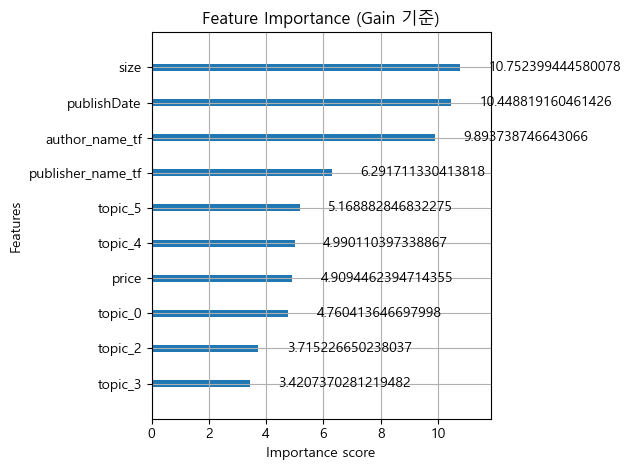

In [36]:
# 피처 중요도 시각화 (Gain 기준)
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title("Feature Importance (Gain 기준)")
plt.tight_layout()
plt.show()

c:\Users\hc\anaconda3\envs\py310\lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  pl.tight_layout()
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


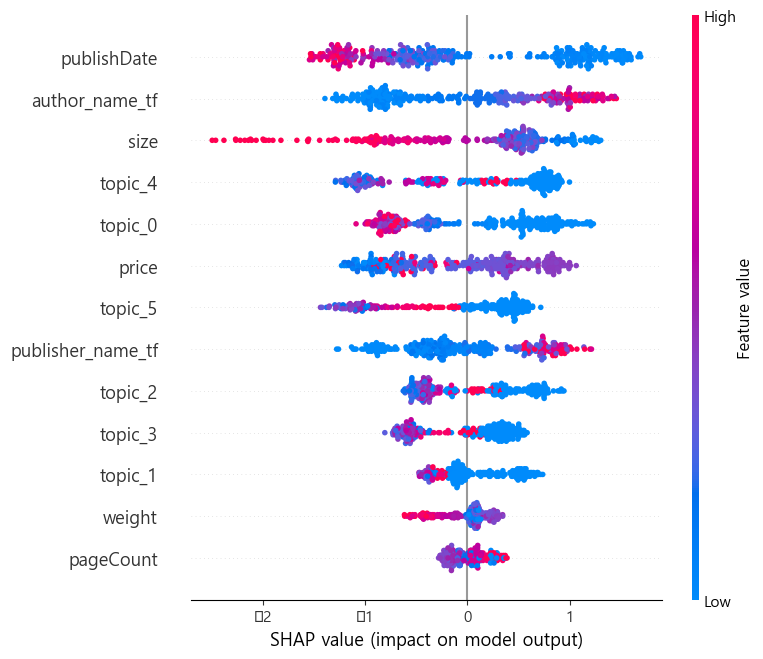

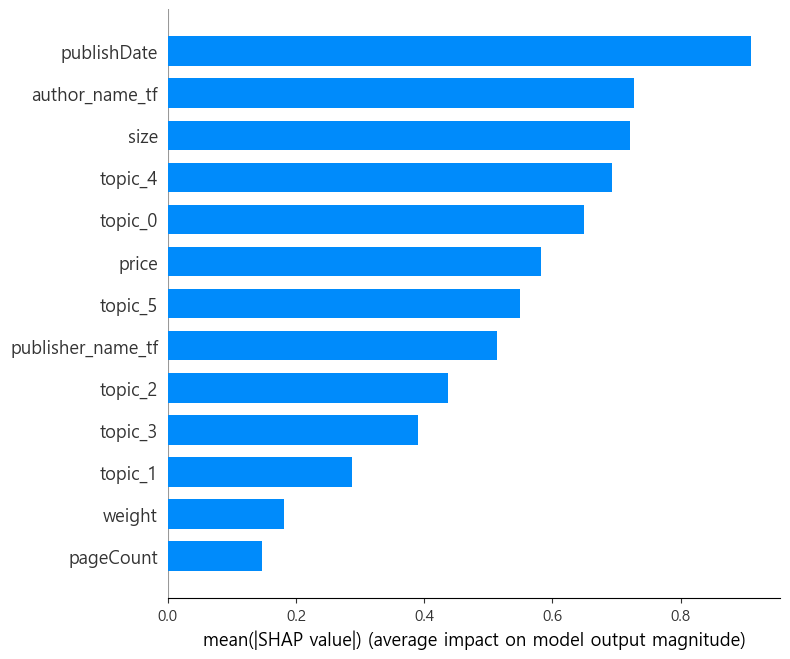

In [37]:
import shap

# SHAP 값 계산
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_val)

# 요약 시각화 (Summary plot)
shap.summary_plot(shap_values, X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")

In [38]:
print("Train Accuracy:", accuracy_score(y_train, best_model.predict(X_train)))
print("Val Accuracy:", accuracy_score(y_val, best_model.predict(X_val)))

Train Accuracy: 0.9657293497363796
Val Accuracy: 0.9601226993865031
